In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import librosa
import sys
import gc
import csv
from IPython.display import Audio
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_hub as hub
from tensorflow import keras

# 1. Load and Understanding Data

## Meta Data of Train Data

In [2]:
input_dirs = glob.glob("/kaggle/input/birdclef-2023/*")
# ['/kaggle/input/birdclef-2023/sample_submission.csv', '/kaggle/input/birdclef-2023/train_audio', '/kaggle/input/birdclef-2023/eBird_Taxonomy_v2021.csv', '/kaggle/input/birdclef-2023/train_metadata.csv', '/kaggle/input/birdclef-2023/test_soundscapes']
print(f"input directories:{input_dirs}")
SAMPLE_SUBMISSIONS_PATH = input_dirs[0]
TRAIN_DIR_PATH = input_dirs[1]
EBIRD_TAXONOMY_CSV_PATH = input_dirs[2]
TRAIN_METADATA_CSV_PATH = input_dirs[3]
TEST_SOUND_DIR_PATH = input_dirs[4]

input directories:['/kaggle/input/birdclef-2023/sample_submission.csv', '/kaggle/input/birdclef-2023/train_audio', '/kaggle/input/birdclef-2023/eBird_Taxonomy_v2021.csv', '/kaggle/input/birdclef-2023/train_metadata.csv', '/kaggle/input/birdclef-2023/test_soundscapes']


In [3]:
#下記のコードでtrain_audioのディレクトリ内はすべてフォルダであることを確認
not_dir_list_in_train_audio = [i for i in glob.glob(f"{TRAIN_DIR_PATH}/*") if os.path.isdir(i)==False]
print(not_dir_list_in_train_audio)

[]


In [4]:
ALL_TRAIN_DIR = glob.glob(f"{TRAIN_DIR_PATH}/*")
NUM_TRAIN_DIR = len(ALL_TRAIN_DIR)
# print(f"All train dirs:{ALL_TRAIN_DIR}")
print(f"The number of train audio directories: {NUM_TRAIN_DIR}")

The number of train audio directories: 264


In [5]:
train_data_dict = {}
for i, train_dir in enumerate(ALL_TRAIN_DIR):
    train_sound_data = glob.glob(f"{train_dir}/*")
    train_dir_name = os.path.basename(train_dir)
    train_data_dict[train_dir_name] = [len(train_sound_data)]
    #print(f"Num of {train_dir_name}: {len(train_sound_data)}")
# print(train_data_dict)
train_data_dirs_df = pd.DataFrame.from_dict(train_data_dict)
train_data_dirs_df.index = ["Num of data"]
train_data_dirs_df

yetgre1  moccha1  rostur1  walsta1  ratcis1  norfis1  macshr1  \
Num of data       27       36       10       34      172       20        6   

             brrwhe3  crefra2  pabspa1  ...  barswa  categr  reedov1  blaplo1  \
Num of data        8        1        7  ...     500     166       70       50   

             litegr  egygoo  rehwea1  fatwid1  blcapa2  edcsun3  
Num of data     378     152        5        5       22       21  

[1 rows x 264 columns]

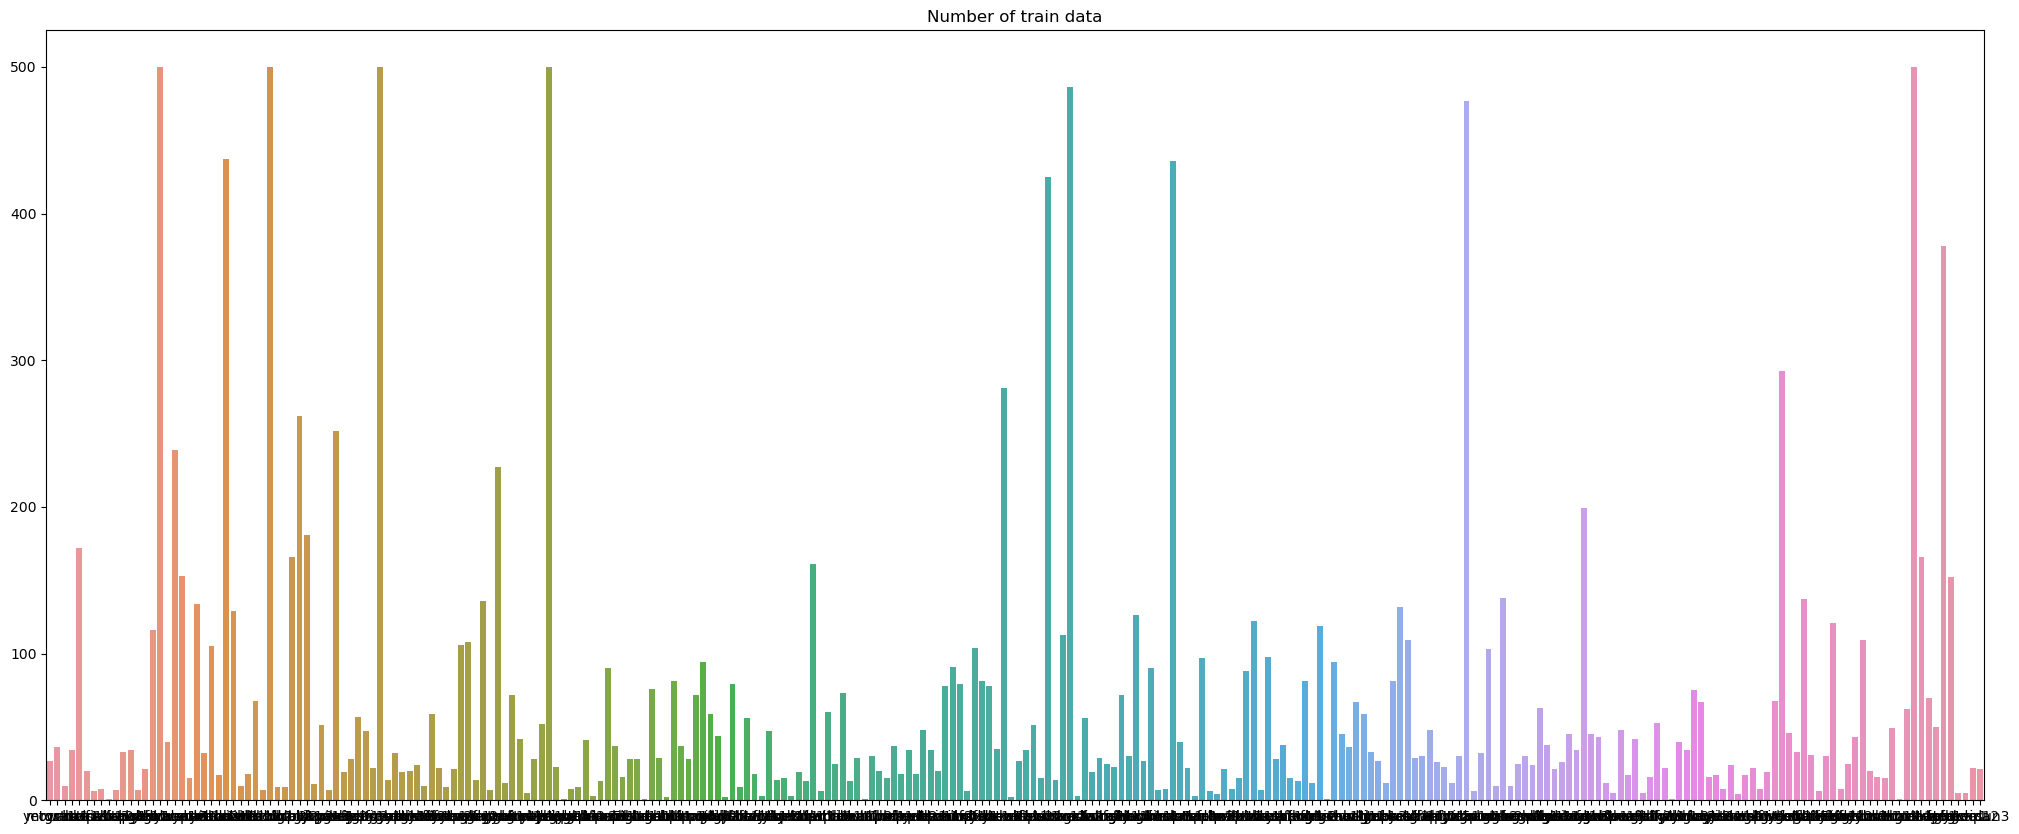

In [6]:
fig = plt.figure(figsize=(25, 10))
sns.barplot(train_data_dirs_df)
plt.title("Number of train data")
plt.show()

In [7]:
ebird_taxonomy_df = pd.read_csv(EBIRD_TAXONOMY_CSV_PATH)
ebird_taxonomy_df

TAXON_ORDER CATEGORY SPECIES_CODE         PRIMARY_COM_NAME  \
0                1  species      ostric2           Common Ostrich   
1                6  species      ostric3           Somali Ostrich   
2                7    slash       y00934    Common/Somali Ostrich   
3                8  species      grerhe1             Greater Rhea   
4               14  species      lesrhe2              Lesser Rhea   
...            ...      ...          ...                      ...   
16748        34694  species      slcgro1   Slate-colored Grosbeak   
16749        34697  species      bltgro2  Black-throated Grosbeak   
16750        34698     spuh      saltat1             saltator sp.   
16751        34699     spuh      passer1            passerine sp.   
16752        35000     spuh        bird1                 bird sp.   

                             SCI_NAME            ORDER1  \
0                    Struthio camelus  Struthioniformes   
1              Struthio molybdophanes  Struthioniformes   
2      Struthio camelus/molybdophanes  Struthioniformes   
3                      Rhea americana        Rheiformes   
4                        Rhea pennata        Rheiformes   
...                               ...               ...   
16748                Saltator grossus     Passeriformes   
16749            Saltator fuliginosus     Passeriformes   
16750                    Saltator sp.     Passeriformes   
16751               Passeriformes sp.     Passeriformes   
16752                        Aves sp.               NaN   

                                 FAMILY SPECIES_GROUP REPORT_AS  
0             Struthionidae (Ostriches)     Ostriches       NaN  
1             Struthionidae (Ostriches)           NaN       NaN  
2             Struthionidae (Ostriches)           NaN       NaN  
3                       Rheidae (Rheas)         Rheas       NaN  
4                       Rheidae (Rheas)           NaN       NaN  
...                                 ...           ...       ...  
16748  Thraupidae (Tanagers and Allies)           NaN       NaN  
16749  Thraupidae (Tanagers and Allies)           NaN       NaN  
16750  Thraupidae (Tanagers and Allies)           NaN       NaN  
16751                               NaN        Others       NaN  
16752                               NaN           NaN       NaN  

[16753 rows x 9 columns]

In [8]:
train_meta_df = pd.read_csv(TRAIN_METADATA_CSV_PATH)
train_meta_df

primary_label secondary_labels              type  latitude  longitude  \
0           abethr1               []          ['song']    4.3906    38.2788   
1           abethr1               []          ['call']   -2.9524    38.2921   
2           abethr1               []          ['song']   -2.9524    38.2921   
3           abethr1               []          ['song']   -2.9524    38.2921   
4           abethr1               []  ['call', 'song']   -2.9524    38.2921   
...             ...              ...               ...       ...        ...   
16936       yewgre1               []              ['']   -1.2502    29.7971   
16937       yewgre1               []              ['']   -1.2489    29.7923   
16938       yewgre1               []              ['']   -1.2433    29.7844   
16939       yewgre1               []              ['']    0.0452    36.3699   
16940       yewgre1               []              ['']   -0.3986    37.3087   

            scientific_name                common_name          author  \
0        Turdus tephronotus   African Bare-eyed Thrush   Rolf A. de By   
1        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
2        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
3        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
4        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
...                     ...                        ...             ...   
16936  Eurillas latirostris  Yellow-whiskered Greenbul  András Schmidt   
16937  Eurillas latirostris  Yellow-whiskered Greenbul  András Schmidt   
16938  Eurillas latirostris  Yellow-whiskered Greenbul  András Schmidt   
16939  Eurillas latirostris  Yellow-whiskered Greenbul   Lars Lachmann   
16940  Eurillas latirostris  Yellow-whiskered Greenbul   Lars Lachmann   

                                                 license  rating  \
0      Creative Commons Attribution-NonCommercial-Sha...     4.0   
1      Creative Commons Attribution-NonCommercial-Sha...     3.5   
2      Creative Commons Attribution-NonCommercial-Sha...     3.5   
3      Creative Commons Attribution-NonCommercial-Sha...     5.0   
4      Creative Commons Attribution-NonCommercial-Sha...     4.5   
...                                                  ...     ...   
16936  Creative Commons Attribution-NonCommercial-Sha...     3.0   
16937  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16938  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16939  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16940  Creative Commons Attribution-NonCommercial-Sha...     4.5   

                                     url              filename  
0      https://www.xeno-canto.org/128013  abethr1/XC128013.ogg  
1      https://www.xeno-canto.org/363501  abethr1/XC363501.ogg  
2      https://www.xeno-canto.org/363502  abethr1/XC363502.ogg  
3      https://www.xeno-canto.org/363503  abethr1/XC363503.ogg  
4      https://www.xeno-canto.org/363504  abethr1/XC363504.ogg  
...                                  ...                   ...  
16936      https://xeno-canto.org/703472  yewgre1/XC703472.ogg  
16937      https://xeno-canto.org/703485  yewgre1/XC703485.ogg  
16938      https://xeno-canto.org/704433  yewgre1/XC704433.ogg  
16939      https://xeno-canto.org/752974  yewgre1/XC752974.ogg  
16940      https://xeno-canto.org/753190  yewgre1/XC753190.ogg  

[16941 rows x 12 columns]

In [9]:
train_meta_taxonomy_df = pd.merge(train_meta_df, ebird_taxonomy_df, left_on='scientific_name', right_on='SCI_NAME').drop(columns='SCI_NAME')
train_meta_taxonomy_df

primary_label secondary_labels              type  latitude  longitude  \
0           abethr1               []          ['song']    4.3906    38.2788   
1           abethr1               []          ['call']   -2.9524    38.2921   
2           abethr1               []          ['song']   -2.9524    38.2921   
3           abethr1               []          ['song']   -2.9524    38.2921   
4           abethr1               []  ['call', 'song']   -2.9524    38.2921   
...             ...              ...               ...       ...        ...   
16697       yewgre1               []              ['']   -1.2502    29.7971   
16698       yewgre1               []              ['']   -1.2489    29.7923   
16699       yewgre1               []              ['']   -1.2433    29.7844   
16700       yewgre1               []              ['']    0.0452    36.3699   
16701       yewgre1               []              ['']   -0.3986    37.3087   

            scientific_name                common_name          author  \
0        Turdus tephronotus   African Bare-eyed Thrush   Rolf A. de By   
1        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
2        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
3        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
4        Turdus tephronotus   African Bare-eyed Thrush   James Bradley   
...                     ...                        ...             ...   
16697  Eurillas latirostris  Yellow-whiskered Greenbul  András Schmidt   
16698  Eurillas latirostris  Yellow-whiskered Greenbul  András Schmidt   
16699  Eurillas latirostris  Yellow-whiskered Greenbul  András Schmidt   
16700  Eurillas latirostris  Yellow-whiskered Greenbul   Lars Lachmann   
16701  Eurillas latirostris  Yellow-whiskered Greenbul   Lars Lachmann   

                                                 license  rating  \
0      Creative Commons Attribution-NonCommercial-Sha...     4.0   
1      Creative Commons Attribution-NonCommercial-Sha...     3.5   
2      Creative Commons Attribution-NonCommercial-Sha...     3.5   
3      Creative Commons Attribution-NonCommercial-Sha...     5.0   
4      Creative Commons Attribution-NonCommercial-Sha...     4.5   
...                                                  ...     ...   
16697  Creative Commons Attribution-NonCommercial-Sha...     3.0   
16698  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16699  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16700  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16701  Creative Commons Attribution-NonCommercial-Sha...     4.5   

                                     url              filename  TAXON_ORDER  \
0      https://www.xeno-canto.org/128013  abethr1/XC128013.ogg        27584   
1      https://www.xeno-canto.org/363501  abethr1/XC363501.ogg        27584   
2      https://www.xeno-canto.org/363502  abethr1/XC363502.ogg        27584   
3      https://www.xeno-canto.org/363503  abethr1/XC363503.ogg        27584   
4      https://www.xeno-canto.org/363504  abethr1/XC363504.ogg        27584   
...                                  ...                   ...          ...   
16697      https://xeno-canto.org/703472  yewgre1/XC703472.ogg        23539   
16698      https://xeno-canto.org/703485  yewgre1/XC703485.ogg        23539   
16699      https://xeno-canto.org/704433  yewgre1/XC704433.ogg        23539   
16700      https://xeno-canto.org/752974  yewgre1/XC752974.ogg        23539   
16701      https://xeno-canto.org/753190  yewgre1/XC753190.ogg        23539   

      CATEGORY SPECIES_CODE           PRIMARY_COM_NAME         ORDER1  \
0      species      abethr1   African Bare-eyed Thrush  Passeriformes   
1      species      abethr1   African Bare-eyed Thrush  Passeriformes   
2      species      abethr1   African Bare-eyed Thrush  Passeriformes   
3      species      abethr1   African Bare-eyed Thrush  Passeriformes   
4      species      abethr1   African

In [10]:
train_meta_taxonomy_df.describe(include="all")

primary_label secondary_labels      type      latitude     longitude  \
count          16702            16702     16702  16475.000000  16475.000000   
unique           263              751       796           NaN           NaN   
top           barswa               []  ['song']           NaN           NaN   
freq             500            14397      4102           NaN           NaN   
mean             NaN              NaN       NaN     12.783951     22.038549   
std              NaN              NaN       NaN     29.359634     28.865038   
min              NaN              NaN       NaN    -38.116900   -157.819400   
25%              NaN              NaN       NaN     -6.256000      5.941650   
50%              NaN              NaN       NaN      2.985400     26.729300   
75%              NaN              NaN       NaN     42.965000     36.589100   
max              NaN              NaN       NaN     71.976900    177.684900   

        scientific_name   common_name        author  \
count             16702         16702         16702   
unique              263           263          1082   
top     Hirundo rustica  Barn Swallow  isaac kilusu   
freq                500           500          1109   
mean                NaN           NaN           NaN   
std                 NaN           NaN           NaN   
min                 NaN           NaN           NaN   
25%                 NaN           NaN           NaN   
50%                 NaN           NaN           NaN   
75%                 NaN           NaN           NaN   
max                 NaN           NaN           NaN   

                                                  license        rating  \
count                                               16702  16702.000000   
unique                                                  4           NaN   
top     Creative Commons Attribution-NonCommercial-Sha...           NaN   
freq                                                15295           NaN   
mean                                                  NaN      3.726290   
std                                                   NaN      1.104557   
min                                                   NaN      0.000000   
25%                                                   NaN      3.000000   
50%                                                   NaN      4.000000   
75%                                                   NaN      4.500000   
max                                                   NaN      5.000000   

                                      url              filename   TAXON_ORDER  \
count                               16702                 16702  16702.000000   
unique                              16702                 16702           NaN   
top     https://www.xeno-canto.org/128013  abethr1/XC128013.ogg           NaN   
freq                                    1                     1           NaN   
mean                                  NaN                   NaN  17114.475093   
std                                   NaN                   NaN   9781.295917   
min                                   NaN                   NaN    373.000000   
25%                                   NaN                   NaN   7636.000000   
50%                                   NaN                   NaN  19391.000000   
75%                                   NaN                   NaN  23981.000000   
max                                   NaN                   NaN  31677.000000   

       CATEGORY SPECIES_CODE PRIMARY_COM_NAME         ORDER1  \
count     16702        16702            16702          16702   
unique        1          263              263             18   
top     species       barswa     Barn Swallow  Passeriformes   
freq      16702          500              500           9382   
mean        NaN          NaN              NaN            NaN   
std         NaN          NaN              NaN            NaN   
min         NaN          NaN              NaN            NaN   
25%        

In [11]:
null_label = train_meta_taxonomy_df.isnull().sum()
print(null_label)
print(type(null_label))

primary_label           0
secondary_labels        0
type                    0
latitude              227
longitude             227
scientific_name         0
common_name             0
author                  0
license                 0
rating                  0
url                     0
filename                0
TAXON_ORDER             0
CATEGORY                0
SPECIES_CODE            0
PRIMARY_COM_NAME        0
ORDER1                  0
FAMILY                  0
SPECIES_GROUP       15650
REPORT_AS           16702
dtype: int64
<class 'pandas.core.series.Series'>


In [12]:
#不要なカラムをドロップ
train_meta_taxonomy_df.drop(["common_name", "url", "SPECIES_CODE", "PRIMARY_COM_NAME", "CATEGORY", "REPORT_AS"], axis=1, inplace=True)

train_meta_taxonomy_df

primary_label secondary_labels              type  latitude  longitude  \
0           abethr1               []          ['song']    4.3906    38.2788   
1           abethr1               []          ['call']   -2.9524    38.2921   
2           abethr1               []          ['song']   -2.9524    38.2921   
3           abethr1               []          ['song']   -2.9524    38.2921   
4           abethr1               []  ['call', 'song']   -2.9524    38.2921   
...             ...              ...               ...       ...        ...   
16697       yewgre1               []              ['']   -1.2502    29.7971   
16698       yewgre1               []              ['']   -1.2489    29.7923   
16699       yewgre1               []              ['']   -1.2433    29.7844   
16700       yewgre1               []              ['']    0.0452    36.3699   
16701       yewgre1               []              ['']   -0.3986    37.3087   

            scientific_name          author  \
0        Turdus tephronotus   Rolf A. de By   
1        Turdus tephronotus   James Bradley   
2        Turdus tephronotus   James Bradley   
3        Turdus tephronotus   James Bradley   
4        Turdus tephronotus   James Bradley   
...                     ...             ...   
16697  Eurillas latirostris  András Schmidt   
16698  Eurillas latirostris  András Schmidt   
16699  Eurillas latirostris  András Schmidt   
16700  Eurillas latirostris   Lars Lachmann   
16701  Eurillas latirostris   Lars Lachmann   

                                                 license  rating  \
0      Creative Commons Attribution-NonCommercial-Sha...     4.0   
1      Creative Commons Attribution-NonCommercial-Sha...     3.5   
2      Creative Commons Attribution-NonCommercial-Sha...     3.5   
3      Creative Commons Attribution-NonCommercial-Sha...     5.0   
4      Creative Commons Attribution-NonCommercial-Sha...     4.5   
...                                                  ...     ...   
16697  Creative Commons Attribution-NonCommercial-Sha...     3.0   
16698  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16699  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16700  Creative Commons Attribution-NonCommercial-Sha...     4.0   
16701  Creative Commons Attribution-NonCommercial-Sha...     4.5   

                   filename  TAXON_ORDER         ORDER1  \
0      abethr1/XC128013.ogg        27584  Passeriformes   
1      abethr1/XC363501.ogg        27584  Passeriformes   
2      abethr1/XC363502.ogg        27584  Passeriformes   
3      abethr1/XC363503.ogg        27584  Passeriformes   
4      abethr1/XC363504.ogg        27584  Passeriformes   
...                     ...          ...            ...   
16697  yewgre1/XC703472.ogg        23539  Passeriformes   
16698  yewgre1/XC703485.ogg        23539  Passeriformes   
16699  yewgre1/XC704433.ogg        23539  Passeriformes   
16700  yewgre1/XC752974.ogg        23539  Passeriformes   
16701  yewgre1/XC753190.ogg        23539  Passeriformes   

                               FAMILY SPECIES_GROUP  
0      Turdidae (Thrushes and Allies)           NaN  
1      Turdidae (Thrushes and Allies)           NaN  
2      Turdidae (Thrushes and Allies)           NaN  
3      Turdidae (Thrushes and Allies)           NaN  
4      Turdidae (Thrushes and Allies)           NaN  
...                               ...           ...  
16697          Pycnonotidae (Bulbuls)           NaN  
16698          Pycnonotidae (Bulbuls)           NaN  
16699          Pycnonotidae (Bulbuls)           NaN  
16700          Pycnonotidae (Bulbuls)           NaN  
16701          Pycnonotidae (Bulbuls)           NaN  

[16702 rows x 14 columns]

In [13]:
def add_others_for_plot_pie(df, column, max_labels=12):
    df_count = df[column].value_counts()
    count_label = []
    count_list = []
    i = 0
    for label, counts in zip(df_count.index, df_count):
        if i < max_labels:
            count_label.append(label)
            count_list.append(counts)
        else:
            if "Others" not in count_label:
                count_label.append("Others")
                count_list.append(0)
            count_list[-1]+=counts
        i += 1
    return count_label, count_list

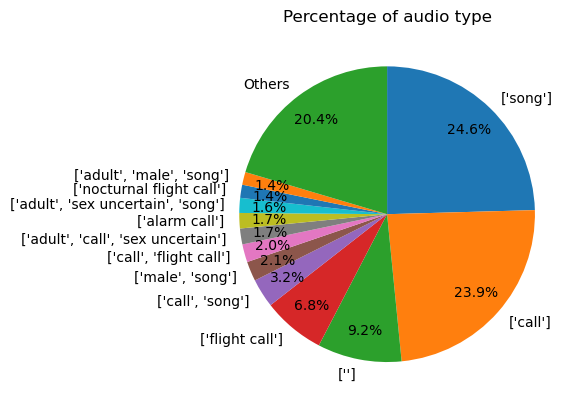

In [14]:
audio_type_count_label, audio_type_count_list = add_others_for_plot_pie(train_meta_taxonomy_df, "type")

# print(audio_type_count_label)
# print(audio_type_count_list)
# plt.pie(audio_type_count, startangle=90, counterclock=False, autopct='%.1f%%', pctdistance=0.8, labels=audio_type_count.index, labeldistance=1.1)
plt.pie(audio_type_count_list, startangle=90, counterclock=False, autopct='%.1f%%', pctdistance=0.8, labels=audio_type_count_label, labeldistance=1.1)
plt.title("Percentage of audio type")

plt.show()

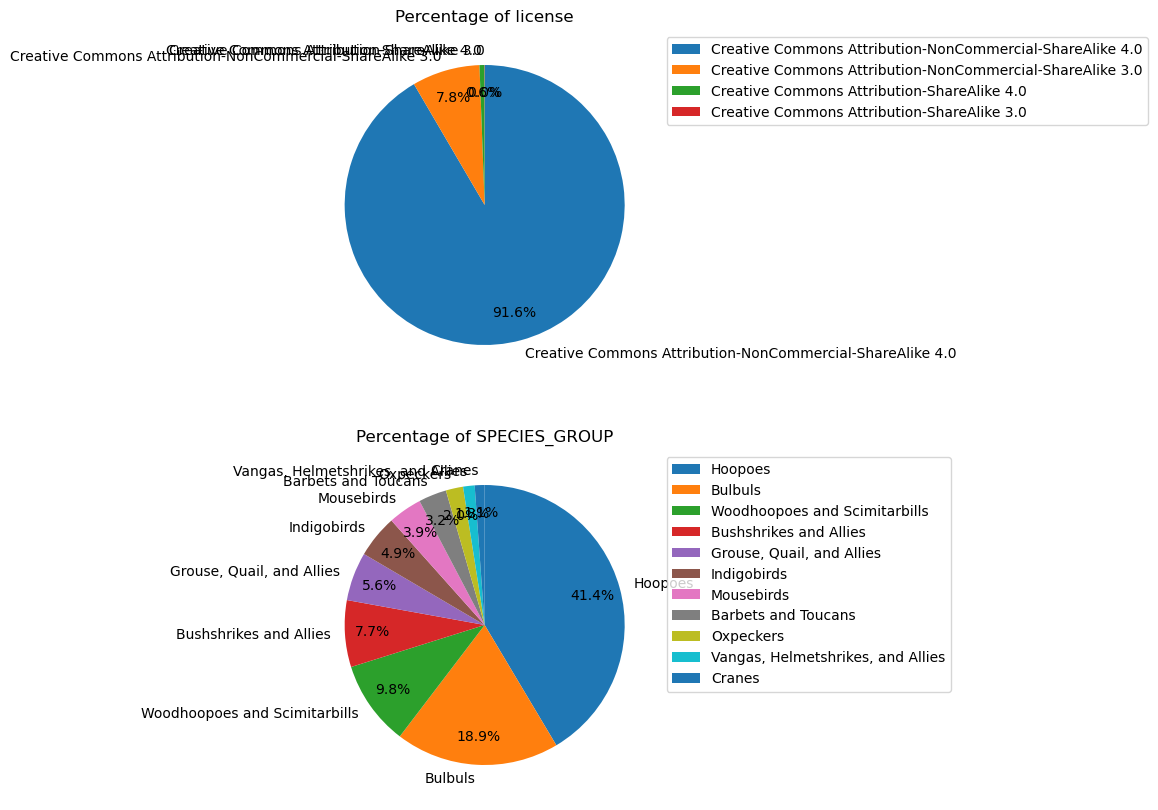

In [15]:
fig = plt.figure(figsize=(15, 10))
for i, column in enumerate(["license", "SPECIES_GROUP"]):
    ax = fig.add_subplot(2, 1, i+1)
    plt.pie(train_meta_taxonomy_df[column].value_counts(), startangle=90, counterclock=False, autopct='%.1f%%', pctdistance=0.8, labels=train_meta_taxonomy_df[column].value_counts().index, labeldistance=1.1)
    plt.title(f"Percentage of {column}")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


In [16]:
#geometry plot
fig =px.scatter_geo(train_meta_taxonomy_df, lat="latitude", lon="longitude", color="primary_label")
fig.show()

In [17]:
sample_submission_df = pd.read_csv(SAMPLE_SUBMISSIONS_PATH)
sample_submission_df

row_id  abethr1  abhori1  abythr1  afbfly1  afdfly1  afecuc1  \
0   soundscape_29201_5        0        0        0        0        0        0   
1  soundscape_29201_10        0        0        0        0        0        0   
2  soundscape_29201_15        0        0        0        0        0        0   

   affeag1  afgfly1  afghor1  ...  yebsto1  yeccan1  yefcan  yelbis1  yenspu1  \
0        0        0        0  ...        0        0       0        0        0   
1        0        0        0  ...        0        0       0        0        0   
2        0        0        0  ...        0        0       0        0        0   

   yertin1  yesbar1  yespet1  yetgre1  yewgre1  
0        0        0        0        0        0  
1        0        0        0        0        0  
2        0        0        0        0        0  

[3 rows x 265 columns]

### Points
 - 種類は263種類。種類によって訓練データの数が違う。500件程度のものもあれば1件しかないものもある。
 - 多クラス分類問題になるためモデルの分類手法を考慮する必要がありそう
   - One-vs-Rest：必要なモデルの数は263
   - One-vs-One：必要なモデルの数は${}_{263} C_{2} = 34453$となり、現実的ではない。。
   - softmax：今回のコンペの評価指標から考えてもこのタイプのモデルを使うのが妥当そうである。つまり、ディープラーニングが有効そう
 - データ量的にすべてのデータを学習することは難しそうなので工夫が必要
   - pandasのデータ読み込み時に利用するデータタイプを指定する（デフォルトではdtype=objectやint64, float64が利用されてしまう）
   - 不要なデータはgc.collect()でメモリを解放
   - 波形データのサンプリング周波数を下げて学習させる
   - 学習させるデータを絞る。その際に、データが豊富な種類のものをアンダーサンプリングして、データが少ない種類のものはできるだけデータを削除しないように工夫する？
   - 学習データを分割してミニバッチ的に学習を行う
   - メモリの大きなPCを利用する、外部ストレージを利用するなどして利用できるリソース容量を増やす
   - 学習済みのモデルを使った転移学習を使う
 - "Common Name"や"Scientific Name"で種名の類似度が高ければ、似ている鳴き声になるという傾向がありそう（と予想）
 - 種によっては地域の違いで鳴き声に違いがあることがあるのでそれを考慮して学習できれば良い
 - 収集した人物によっては「ツバメ類の専門家」などということがあり得るので、データ収集者も考慮に入れて学習できると良い
 - データの内容を見た感じだと、"license"はデータの利用できるライセンス形態を意味しており、学習にはそこまで重要ではなさそう
 - 訓練データの"type"には"['']"というラベルのものがあり、これはNullと同一の意味を表してそう
 - ドロップするカラムについての判断は下記の通り
   - 訓練データの"primary_label"と"common_name"はどちらも種の識別子として同一の意味を表していそうなので片方はドロップ
   - どうやら、訓練データ内の"primary_label", "scientific_name", "common_name"はそれぞれEBIRD分類データの"SPECIES_CODE", "SCI_NAME", "PRIMARY_COM_NAME"と同一
   - "CATEGORY"はすべて同一の値が入っているのでドロップして良さそう
   - "url"は音声データのURLを意味しており、"filename"とほぼ同一の意味として良さそう。利便性を考慮してDataFrameに"filename"を残しても良いが、学習の際にはドロップする必要あり
   - "REPORT_AS"カラムには何のデータもないのでドロップして良さそう

## Audio Data

In [18]:
# Load a sample audio files from two different species
# sr:サンプリング周波数
audio_abe, sr_abe = librosa.load("/kaggle/input/birdclef-2023/train_audio/abethr1/XC128013.ogg")
audio_abh, sr_abh = librosa.load("/kaggle/input/birdclef-2023/train_audio/abhori1/XC127317.ogg")

In [19]:
# Play the audio
Audio(data=audio_abe, rate=sr_abe)

In [20]:
print(audio_abe)
print(audio_abe.dtype)

[-2.0752661e-06 -6.3113657e-07  1.0178218e-06 ... -3.8138585e-04
  6.7974709e-04  7.5442006e-04]
float32


In [21]:
print(sr_abe)

22050


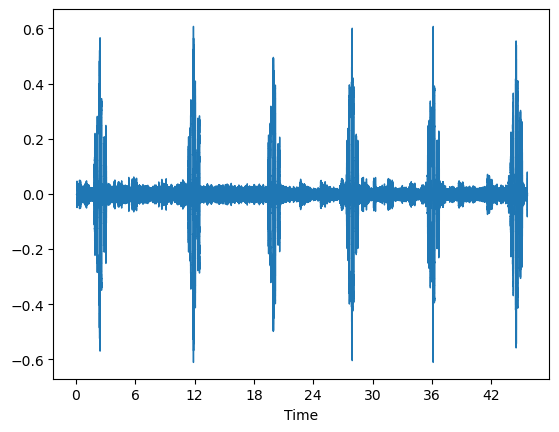

In [22]:
librosa.display.waveshow(audio_abe, sr=sr_abe)
plt.show()

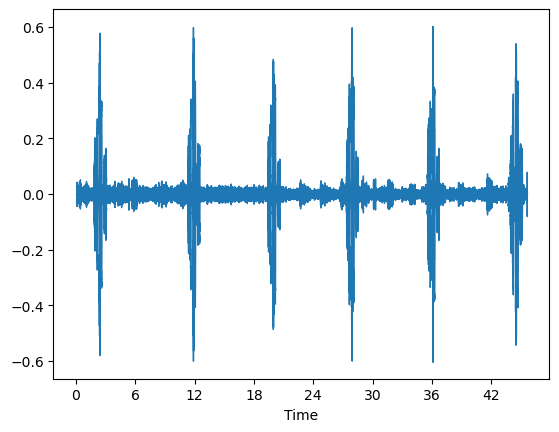

In [23]:
audio_abe_small, sr_abe_small = librosa.load("/kaggle/input/birdclef-2023/train_audio/abethr1/XC128013.ogg", sr=10000)
librosa.display.waveshow(audio_abe_small, sr=sr_abe_small)
plt.show()

In [24]:
# Play the audio
Audio(data=audio_abh, rate=sr_abh)

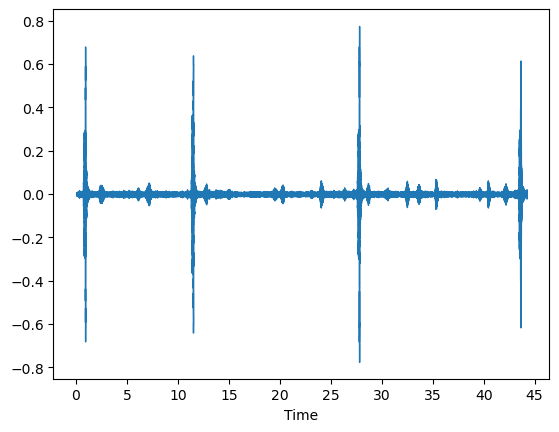

In [25]:
librosa.display.waveshow(audio_abh, sr=sr_abh)
plt.show()

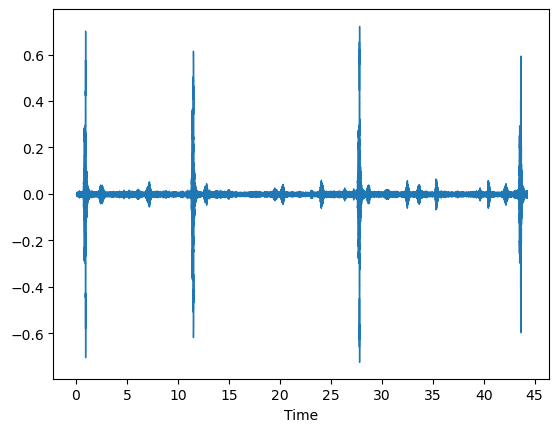

In [26]:
audio_abh_small, sr_abh_small = librosa.load("/kaggle/input/birdclef-2023/train_audio/abhori1/XC127317.ogg", sr=10000)
librosa.display.waveshow(audio_abh_small, sr=sr_abh_small)
plt.show()

In [27]:
print(f"Original data size:{len(audio_abh)}")
print(f"Original data size:{sys.getsizeof(audio_abh)}")
print(f"Compressed data size:{len(audio_abh_small)}")
print(f"Compressed data size:{sys.getsizeof(audio_abh_small)}")

Original data size:975581
Original data size:3902428
Compressed data size:442440
Compressed data size:104


In [28]:
def load_audio_data(filename, sr=22050):
    filepath = os.path.join(TRAIN_DIR_PATH, filename)
    audio_data, sr = librosa.load(filepath)
    return audio_data, sr

In [29]:
#下記のコードをコメントアウトを解除して実行すれば全データに対して音声データの読み込みができる。ただし、時間とリソースがかかるので実装方法については要検討
# train_meta_taxonomy_df["Audio_data"], train_meta_taxonomy_df["sr"] = train_meta_taxonomy_df["filename"].apply(load_audio_data)
# train_meta_taxonomy_df

In [30]:
# サンプリング周波数を下げてデータ量を減らしたうえで音声データの読み込みを実行。しかし、これでも失敗
# train_meta_taxonomy_df["Audio_data"] = train_meta_taxonomy_df["filename"].apply(load_audio_data, sr=10000)
# train_meta_taxonomy_df

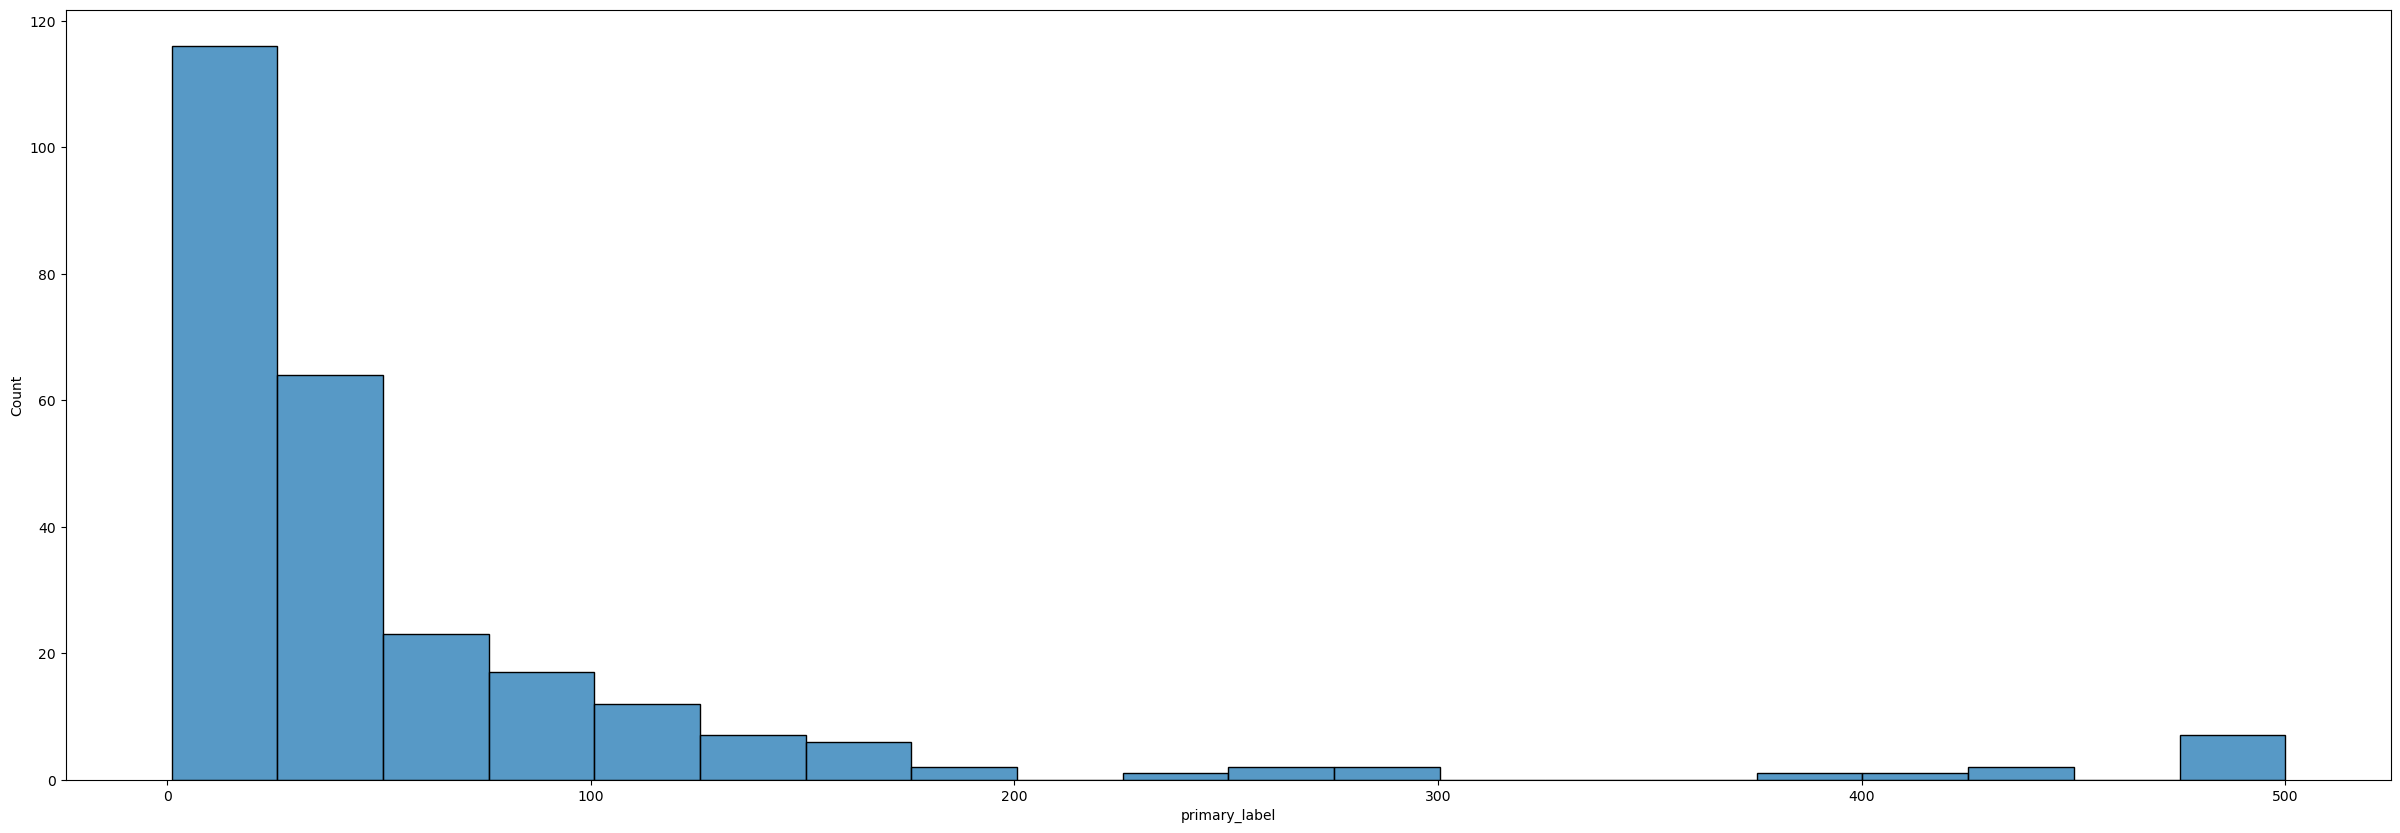

In [31]:
#度数分布
train_df = train_meta_taxonomy_df[["primary_label", "filename"]]
num_counts_list = train_df["primary_label"].value_counts()
plt.figure(figsize=(30, 10))
# sns.countplot(data=num_counts_list, x=num_counts_list.index, order=num_counts_list)
# sns.countplot(x=train_df["primary_label"])
sns.histplot(data=train_df["primary_label"].value_counts(), bins=20)
plt.show()

In [32]:
#取得されているデータ数に応じて学習に使うデータを絞ったうえでランダムに取得して学習させるデータを作成
label_list = []
number_list = []
number_list_after = []
df_small = pd.DataFrame()
for label in train_df["primary_label"].unique():
    label_list.append(label)
    temp_df = train_df[train_df["primary_label"] == label]
    number = len(temp_df)
    number_list.append(number)
    if number >= 200:
        number = 20
    elif number > 30 and number < 200:
        number = 10
        
    number_list_after.append(number)
    df_small = pd.concat([df_small, temp_df.sample(n=number, random_state=0)], axis=0)
    
print(label_list)
print(number_list_after)
print(df_small)

df_small["Audio_data"] = df_small["filename"].apply(load_audio_data)

['abethr1', 'abhori1', 'abythr1', 'afbfly1', 'afdfly1', 'afecuc1', 'affeag1', 'afgfly1', 'afghor1', 'afmdov1', 'afpfly1', 'afpkin1', 'afpwag1', 'afrgos1', 'afrgrp1', 'afrjac1', 'afrthr1', 'amesun2', 'augbuz1', 'bagwea1', 'barswa', 'bawhor2', 'bawman1', 'bcbeat1', 'beasun2', 'bkctch1', 'bkfruw1', 'blacra1', 'blacuc1', 'blakit1', 'blaplo1', 'blbpuf2', 'blcapa2', 'blfbus1', 'blhgon1', 'blhher1', 'blksaw1', 'blnmou1', 'blnwea1', 'bltapa1', 'bltbar1', 'bltori1', 'blwlap1', 'brcale1', 'brcsta1', 'brctch1', 'brcwea1', 'brican1', 'brobab1', 'broman1', 'brosun1', 'brrwhe3', 'brtcha1', 'brubru1', 'brwwar1', 'bswdov1', 'btweye2', 'bubwar2', 'butapa1', 'cabgre1', 'carcha1', 'carwoo1', 'categr', 'ccbeat1', 'chespa1', 'chewea1', 'chibat1', 'chtapa3', 'chucis1', 'cibwar1', 'cohmar1', 'colsun2', 'combul2', 'combuz1', 'comsan', 'crefra2', 'crheag1', 'crohor1', 'darbar1', 'darter3', 'didcuc1', 'dotbar1', 'dutdov1', 'easmog1', 'eaywag1', 'edcsun3', 'egygoo', 'equaka1', 'eswdov1', 'eubeat1', 'fatrav1', 'f

In [33]:
df_small

primary_label              filename  \
1           abethr1  abethr1/XC363501.ogg   
6           abethr1  abethr1/XC432639.ogg   
8           abethr1  abethr1/XC467122.ogg   
9           abethr1  abethr1/XC531557.ogg   
14          abethr1  abethr1/XC756300.ogg   
...             ...                   ...   
16694       yewgre1  yewgre1/XC675467.ogg   
16701       yewgre1  yewgre1/XC753190.ogg   
16601       yewgre1  yewgre1/XC131906.ogg   
16610       yewgre1  yewgre1/XC233084.ogg   
16680       yewgre1  yewgre1/XC478540.ogg   

                                              Audio_data  
1      ([1.065839e-06, 2.7636981e-06, -1.6807759e-06,...  
6      ([3.525532e-06, -1.7013946e-05, -7.832512e-06,...  
8      ([1.2651302e-07, 4.03153e-06, 2.0974646e-06, -...  
9      ([-7.2940334e-06, -1.8474255e-05, 7.1951813e-0...  
14     ([-4.0199306e-05, -7.818411e-06, 6.860722e-06,...  
...                                                  ...  
16694  ([-1.2219234e-05, -1.4064062e-05, 2.9822051e-0...  
16701  ([-8.526033e-06, -3.2108362e-06, -5.7243506e-0...  
16601  ([-4.8065604e-06, -2.1804994e-05, 9.491709e-06...  
16610  ([1.8478418e-05, -2.157617e-06, 3.4704005e-06,...  
16680  ([5.8888586e-06, -9.9375775e-06, 1.351487e-05,...  

[3492 rows x 3 columns]

In [34]:
df_small = df_small.sample(frac=1, random_state=0)
df_small

primary_label              filename  \
5734        dotbar1  dotbar1/XC244611.ogg   
14330       vilwea1  vilwea1/XC153678.ogg   
2875        bswdov1  bswdov1/XC745607.ogg   
757         afrjac1  afrjac1/XC515846.ogg   
15257        wlwwar   wlwwar/XC543960.ogg   
...             ...                   ...   
2992        cabgre1  cabgre1/XC124658.ogg   
16035       wtbeat1  wtbeat1/XC402107.ogg   
8950         hoopoe   hoopoe/XC593327.ogg   
12196       shesta1  shesta1/XC209999.ogg   
12678       soucit1  soucit1/XC627239.ogg   

                                              Audio_data  
5734   ([1.2170687e-05, 1.2673713e-05, 2.7700185e-06,...  
14330  ([5.8601677e-06, -1.2507829e-05, -1.3582925e-0...  
2875   ([-1.2154396e-07, -2.662235e-05, -1.5409974e-0...  
757    ([-1.1994137e-05, -1.0720294e-05, 3.636921e-06...  
15257  ([-4.5323873e-06, 2.3226487e-06, 1.2395074e-06...  
...                                                  ...  
2992   ([2.0382487e-05, -2.2856651e-05, -2.334705e-05...  
16035  ([-3.9986648e-07, -4.2187717e-06, 1.9817402e-0...  
8950   ([-2.3615466e-05, -1.9026958e-05, 8.46337e-06,...  
12196  ([-4.6097148e-07, -6.927365e-07, -1.3408329e-0...  
12678  ([-9.767317e-07, -2.7066855e-05, 1.09695275e-0...  

[3492 rows x 3 columns]

In [35]:
#簡単にX,yを作成してみる。ただし、データ数が1個のみのものは確実に訓練データに含めるなどの対応がほんとは必要
X = df_small["Audio_data"].values
le = LabelEncoder()
y = le.fit_transform(df_small["primary_label"].values)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [36]:
# Example of Metric Code
def padded_cmap(solution, submission, padding_factor=5):
    solution = solution.drop(['row_id'], axis=1, errors='ignore')
    submission = submission.drop(['row_id'], axis=1, errors='ignore')
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

In [37]:
class ModelSelection:
    def __init__(self, model_list:list, model_labels_list:list=[], is_predict_proba:bool=False, custom_score=None):
        #定義したモデルのインスタンスを格納
        self.model_list = model_list
        
        #モデルの種類のラベルを格納（例："モデル１", "ランダムフォレスト", ...）
        if model_labels_list == []:
            self.model_labels_list = [f"Model {i}" for i in range(len(model_list))]
        else:
            self.model_labels_list = model_labels_list
        
        #各モデルのスコアのリストを定義
        self.score_dict = {}
        self.is_custom_score_defined = bool(custom_score)
        if custom_score:
            #スコアを算出する関数を保管
            self.custom_score_func = custom_score
        
        #確率まで予測するか
        self.is_predict_proba = is_predict_proba
    
    def get_all_model_scores(self, X_train, X_test, y_train, y_test):
        """すべてのモデルのデフォルト値に対するスコアを算出してメンバ変数に格納
        """
        for i, model in enumerate(self.model_list):
            model_label = self.model_labels_list[i]
            self.get_specific_model_scores(model, model_label, X_train, X_test, y_train, y_test)
        
    #モデル名をキーとした辞書型のリストを作成できるように改良
    #例 {"model1":{"accuracy_score":0.88, "precision_score":0.76, "recall_score":0.78, ...}, "model2":{"accuracy_score":0.78, ...}, ...}
    def get_specific_model_scores(self, model, model_label, X_train, X_test, y_train, y_test):
        try:
            model_dict = {}
            model.fit(X_train, y_train)
            X_train_predict = model.predict(X_train)
            X_test_predict = model.predict(X_test)
            
            model_dict["Train Accuracy"] = accuracy_score(y_true=y_train, y_pred=X_train_predict)
            model_dict["Test Accuracy"] = accuracy_score(y_true=y_test, y_pred=X_test_predict)
            model_dict["Test Precision"] = precision_score(y_true=y_test, y_pred=X_test_predict)
            model_dict["Test Recall"] = recall_score(y_true=y_test, y_pred=X_test_predict)
            model_dict["Test F1 Score"] = f1_score(y_true=y_test, y_pred=X_test_predict)
            
            if self.is_predict_proba:
                test_prob = model.predict_proba(X_test)[:, 1] # 目的変数が1である確率を予測
                model_dict["Log Loss"] = log_loss(y_true=y_test, y_pred=test_prob)
            #下記で関数を適用する方法を調べる必要あり
            if self.is_custom_score_defined:
                custom_score = self.custom_score_func(y_test, X_test)
                model_dict["Test Custom Score"] = custom_score
            self.score_dict[model_label] = model_dict
            print(f"model_label:{model_label} succeeded.")
        except Exception as e:
            self.score_dict[model_label] = model_dict
            print(f"Something Error has occured. The error messages are below:")
            print(f"{e}")
    

    def get_summary_results(self):
        result_df = pd.DataFrame(self.score_dict)
        return result_df

In [38]:
# model_labels_list = ["XGBClassifier", "CatBoostClassifier", "LGBMClassifier"]
# model_list = [XGBClassifier(random_state=0), CatBoostClassifier(silent=True, random_state=0), LGBMClassifier(random_state =0)]

In [39]:
# model_selection_class = ModelSelection(model_list, model_labels_list, custom_score=padded_cmap)
# model_selection_class.get_all_model_scores(X_train, X_test, y_train, y_test)
# model_selection_class.get_summary_results()

In [40]:
def frame_audio(
      audio_array: np.ndarray,
      window_size_s: float = 5.0,
      hop_size_s: float = 5.0,
      sample_rate = 32000,
      ) -> np.ndarray:
    
    """Helper function for framing audio for inference."""
    """ using tf.signal """
    if window_size_s is None or window_size_s < 0:
        return audio_array[np.newaxis, :]
    frame_length = int(window_size_s * sample_rate)
    hop_length = int(hop_size_s * sample_rate)
    framed_audio = tf.signal.frame(audio_array, frame_length, hop_length, pad_end=True)
    return framed_audio

def ensure_sample_rate(waveform, original_sample_rate,
                       desired_sample_rate=32000):
    """Resample waveform if required."""
    if original_sample_rate != desired_sample_rate:
        waveform = tfio.audio.resample(waveform, original_sample_rate, desired_sample_rate)
    return desired_sample_rate, waveform

In [41]:
def predict_for_sample(filename, sample_submission, frame_limit_secs=None):
    file_id = filename.split(".ogg")[0].split("/")[-1]
    
    audio, sample_rate = librosa.load(filename)
    sample_rate, wav_data = ensure_sample_rate(audio, sample_rate)
    
    fixed_tm = frame_audio(wav_data)
    
    frame = 5
    all_logits, all_embeddings = model.infer_tf(fixed_tm[:1])
    for window in fixed_tm[1:]:
        if frame_limit_secs and frame > frame_limit_secs:
            continue
        
        logits, embeddings = model.infer_tf(window[np.newaxis, :])
        all_logits = np.concatenate([all_logits, logits], axis=0)
        frame += 5
    
    frame = 5
    all_probabilities = []
    for frame_logits in all_logits:
        probabilities = tf.nn.softmax(frame_logits).numpy()
        
        ## set the appropriate row in the sample submission
        sample_submission.loc[sample_submission.row_id == file_id + "_" + str(frame), competition_classes] = probabilities[competition_class_map]
        frame += 5

In [42]:
# model_handle = "https://tfhub.dev/google/bird-vocalization-classifier/1"
# model = hub.load(model_handle)
model_handle = "/kaggle/input/bird-vocalization-classifier/tensorflow2/bird-vocalization-classifier/2"
model = tf.keras.models.load_model(model_handle)

In [43]:
#学習済みのモデルの理解
#tf.shape(model)
# 入力：Shape=(8, 160000) infer:(1, 160000)
# 出力：shape=(1, 10932)

In [44]:
# Find the name of the class with the top score when mean-aggregated across frames.
def class_names_from_csv(class_map_csv_text):
  """Returns list of class names corresponding to score vector."""
  with open(labels_path) as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    class_names = [mid for mid, desc in csv_reader]
    return class_names[1:]

labels_path = hub.resolve(model_handle) + "/assets/label.csv"
classes = class_names_from_csv(labels_path)
#print(classes) #all the classes in pre-trained model
print(f"Number of pre-trained classes:{len(classes)}")

Number of pre-trained classes:10932


In [45]:
learned_csv = pd.read_csv(labels_path)
learned_csv

ebird2021  comment
0       aakspa1      NaN
1       abbbab1      NaN
2       abbboo2      NaN
3       abbsta2      NaN
4       abbwar1      NaN
...         ...      ...
10927   zimwoo2      NaN
10928   zitcis1      NaN
10929   zittyr1      NaN
10930   zoeimp1      NaN
10931    zothaw      NaN

[10932 rows x 2 columns]

In [46]:
learned_csv[learned_csv["ebird2021"]=="abethr1"].index.values

array([8])

In [47]:
competition_classes = sorted(df_small.primary_label.unique())

In [48]:
#df_smallがうまく使えなかったので一旦削除してメモリを解放
del df_small
gc.collect()

138

In [49]:
forced_defaults = 0
competition_class_map = []
competition_class_name_list = []
not_include_class_list = []
for c in competition_classes:
    try:
        i = classes.index(c)
        competition_class_map.append(i)
        competition_class_name_list.append(c)
    except:
        competition_class_map.append(0)
        not_include_class_list.append(c)
        competition_class_name_list.append(c)
        forced_defaults += 1
        
print(competition_class_map)
print(competition_class_name_list)
print(len(competition_class_map))
print(len(competition_class_name_list))
print(f"Number of classes not included in pre-trained model: {forced_defaults}")
print(f"Not included class in pre-trained model:{not_include_class_list}")

[8, 11, 21, 32, 38, 40, 42, 45, 46, 54, 57, 59, 63, 70, 71, 74, 93, 177, 394, 496, 600, 659, 661, 719, 755, 924, 947, 1011, 1012, 1031, 1052, 1118, 1150, 1232, 1287, 1289, 1327, 1354, 1363, 1387, 1389, 1418, 1471, 1638, 1648, 1649, 1652, 1678, 1709, 1732, 1743, 1758, 1766, 1778, 1794, 1800, 1823, 1850, 1937, 1976, 2062, 2084, 2103, 2135, 2275, 2278, 2301, 2380, 2391, 2419, 2526, 2564, 2575, 2579, 2623, 2748, 2783, 2803, 2891, 2899, 2944, 2970, 3065, 3108, 3126, 3139, 3145, 3196, 3203, 3206, 3305, 3307, 3380, 0, 3530, 3551, 3562, 3642, 3651, 3666, 3670, 3720, 3821, 3852, 3884, 3890, 3961, 4055, 4060, 4116, 4160, 4223, 4248, 4262, 4266, 4277, 4304, 4327, 4334, 4355, 4381, 4438, 4489, 4546, 4547, 4744, 4799, 4819, 4851, 4914, 4925, 5014, 5030, 5056, 5115, 5148, 5153, 5192, 5210, 5219, 5286, 5303, 5325, 5402, 5491, 5492, 5592, 5640, 5702, 5830, 5888, 5985, 6008, 6012, 6016, 6035, 6059, 6330, 6402, 6417, 6653, 6664, 6718, 6905, 6952, 0, 7002, 7011, 7034, 7067, 7075, 7085, 7116, 7121, 7174, 

In [50]:
#学習されていなかったデータに新しくIndexを付けて学習ラベルを作成
j = len(learned_csv)
idx = 0
for label_number, label_name in zip(competition_class_map, competition_class_name_list):
    if label_name in not_include_class_list:
        print(f"Not included class label: {label_name}")
        print(f"Assigned class number: {j}")
        competition_class_map[idx] = j
        j+=1
    idx += 1
    
print(competition_class_map)

Not included class label: fotdro5
Assigned class number: 10932
Not included class label: quailf1
Assigned class number: 10933
Not included class label: sacibi2
Assigned class number: 10934
[8, 11, 21, 32, 38, 40, 42, 45, 46, 54, 57, 59, 63, 70, 71, 74, 93, 177, 394, 496, 600, 659, 661, 719, 755, 924, 947, 1011, 1012, 1031, 1052, 1118, 1150, 1232, 1287, 1289, 1327, 1354, 1363, 1387, 1389, 1418, 1471, 1638, 1648, 1649, 1652, 1678, 1709, 1732, 1743, 1758, 1766, 1778, 1794, 1800, 1823, 1850, 1937, 1976, 2062, 2084, 2103, 2135, 2275, 2278, 2301, 2380, 2391, 2419, 2526, 2564, 2575, 2579, 2623, 2748, 2783, 2803, 2891, 2899, 2944, 2970, 3065, 3108, 3126, 3139, 3145, 3196, 3203, 3206, 3305, 3307, 3380, 10932, 3530, 3551, 3562, 3642, 3651, 3666, 3670, 3720, 3821, 3852, 3884, 3890, 3961, 4055, 4060, 4116, 4160, 4223, 4248, 4262, 4266, 4277, 4304, 4327, 4334, 4355, 4381, 4438, 4489, 4546, 4547, 4744, 4799, 4819, 4851, 4914, 4925, 5014, 5030, 5056, 5115, 5148, 5153, 5192, 5210, 5219, 5286, 5303, 53

In [51]:
# #エラー
# feature_extractor_layer = tf.keras.Sequential([hub.KerasLayer(model, input_shape=(1, 160000),trainable=False)])


# num_classes = len(competition_class_map)

# update_model = tf.keras.Sequential([
#   feature_extractor_layer,
#   tf.keras.layers.Dense(num_classes)
# ])

# update_model.summary()


In [63]:
num_classes = len(competition_class_map)

# #ChatGPTに聞いた新しいクラスの学習を含む転移学習の手法
# #1.モデルの読み込み
update_model = tf.keras.models.load_model(model_handle)
# update_model = hub.load(model_handle)
# print(f"Model type:{type(update_model)}")

update_model.summary()
# #2.モデルの最後のレイヤーを除去する
# update_model.pop()

# #3.新しいレイヤーを追加する
# new_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
# update_model.add(new_layer)

# #4.モデルを再学習する
# for layer in update_model.layers[:-1]:
#     layer.trainable = False
# update_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# #update_model.fit(new_data, epochs=10)

# #5.更新されたモデルを保存する
# #update_model.save('model/')

AttributeError: '_UserObject' object has no attribute 'summary'

In [53]:
# Preparing additional training data
INPUT_DIR_PATH = "/kaggle/input/birdclef-2023/train_audio/"
for label in not_include_class_list:
    additional_train_df = train_df[train_df["primary_label"]==label]
    for file in additional_train_df["filename"].values:
        filepath = os.path.join(INPUT_DIR_PATH, file)
        audio, sample_rate = librosa.load(filepath)
        sample_rate, wav_data = ensure_sample_rate(audio, sample_rate)
        fixed_tm = frame_audio(wav_data)
    #additional_train_df = train_df[train_df["primary_label"]==label]
additional_train_df

primary_label              filename
12056       sacibi2  sacibi2/XC252633.ogg
12057       sacibi2  sacibi2/XC309388.ogg
12058       sacibi2  sacibi2/XC417635.ogg
12059       sacibi2  sacibi2/XC505935.ogg
12060       sacibi2  sacibi2/XC652185.ogg
12061       sacibi2  sacibi2/XC661232.ogg

In [54]:
# Pre-process for pre-trained model
audio, sample_rate = librosa.load("/kaggle/input/birdclef-2023/train_audio/afghor1/XC156639.ogg")
sample_rate, wav_data = ensure_sample_rate(audio, sample_rate)

In [55]:
print(wav_data)

tf.Tensor(
[ 3.8444126e-11 -2.7890612e-10 -9.9282881e-11 ... -1.1854604e-06
  1.7903512e-05  6.6926737e-06], shape=(1190349,), dtype=float32)


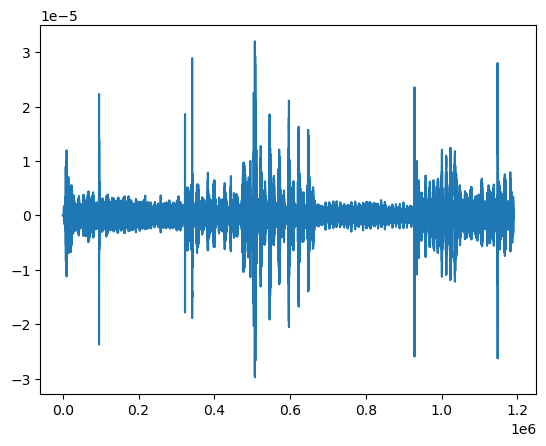

In [56]:
#using tf module
tf_wav_data = tf.cast(wav_data, tf.float32) / sample_rate

plt.figure()
plt.plot(tf_wav_data.numpy())
plt.show()

In [57]:
# Make Prediction using pre-trained model
fixed_tm = frame_audio(wav_data)
print(f"fixed_tm:{fixed_tm}")
print(f"Shape of fixed_tm:{fixed_tm.shape}")
print(f"fixed_tm[:1]:{fixed_tm[:1]}")
training_model_input = fixed_tm[:1]
print(f"Model infer input data shape:{training_model_input.shape}")
logits, embeddings = model.infer_tf(fixed_tm[:1])
probabilities = tf.nn.softmax(logits)
argmax = np.argmax(probabilities)
print(f"The audio is from the class {classes[argmax]} (element:{argmax} in the label.csv file), with probability of {probabilities[0][argmax]}")
print(probabilities)

fixed_tm:[[ 3.8444126e-11 -2.7890612e-10 -9.9282881e-11 ... -3.4600347e-02
  -1.5581155e-02  4.2385777e-04]
 [ 2.8074135e-03 -5.3728614e-03 -1.1968970e-02 ...  8.0558620e-03
   1.0230921e-02  1.6302910e-02]
 [ 2.1931900e-02  2.0712124e-02  1.3785732e-02 ...  1.6267300e-01
   1.9742709e-01  1.9162847e-01]
 ...
 [-2.5715338e-02 -2.9534064e-02 -2.6053539e-02 ...  1.9041094e-04
   5.1489486e-03  2.9467763e-03]
 [-1.9640522e-03 -3.8268822e-03 -7.9105544e-04 ... -1.7896650e-02
  -3.5229456e-02 -4.2330120e-02]
 [-4.5714337e-02 -5.5536300e-02 -6.2137041e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
Shape of fixed_tm:(8, 160000)
fixed_tm[:1]:[[ 3.8444126e-11 -2.7890612e-10 -9.9282881e-11 ... -3.4600347e-02
  -1.5581155e-02  4.2385777e-04]]
Model infer input data shape:(1, 160000)
The audio is from the class afghor1 (element:46 in the label.csv file), with probability of 0.6791694164276123
tf.Tensor(
[[1.1006038e-07 2.8866287e-07 1.5499374e-09 ... 3.0095634e-06
  4.6821919e-05 4.72491

In [58]:
test_samples = list(glob.glob("/kaggle/input/birdclef-2023/test_soundscapes/*.ogg"))
test_samples

['/kaggle/input/birdclef-2023/test_soundscapes/soundscape_29201.ogg']

In [59]:
sample_sub = pd.read_csv("/kaggle/input/birdclef-2023/sample_submission.csv")
sample_sub[competition_classes] = sample_sub[competition_classes].astype(np.float32)
sample_sub.head()

row_id  abethr1  abhori1  abythr1  afbfly1  afdfly1  afecuc1  \
0   soundscape_29201_5      0.0      0.0      0.0      0.0      0.0      0.0   
1  soundscape_29201_10      0.0      0.0      0.0      0.0      0.0      0.0   
2  soundscape_29201_15      0.0      0.0      0.0      0.0      0.0      0.0   

   affeag1  afgfly1  afghor1  ...  yebsto1  yeccan1  yefcan  yelbis1  yenspu1  \
0      0.0      0.0      0.0  ...      0.0      0.0     0.0      0.0      0.0   
1      0.0      0.0      0.0  ...      0.0      0.0     0.0      0.0      0.0   
2      0.0      0.0      0.0  ...      0.0      0.0     0.0      0.0      0.0   

   yertin1  yesbar1  yespet1  yetgre1  yewgre1  
0      0.0      0.0      0.0      0.0      0.0  
1      0.0      0.0      0.0      0.0      0.0  
2      0.0      0.0      0.0      0.0      0.0  

[3 rows x 265 columns]

In [60]:
frame_limit_secs = 15 if sample_sub.shape[0] == 3 else None
for sample_filename in test_samples:
    predict_for_sample(sample_filename, sample_sub, frame_limit_secs=15)

IndexError: index 10932 is out of bounds for axis 0 with size 10932

In [ ]:
sample_sub

In [ ]:
sample_sub.to_csv("submission.csv", index=False)